# Summary

## Project and this notebook
- A paired liver biopsy and plasma proteomics study reveals circulating biomarkers for alcohol-related liver disease
- bioRxiv preprint: 

- This notebook contains proteomics data anlaysis in the ALD study that are performed in Python scripts. For the machine learning pipeline, please refer to ALD-ML.ipynb in the same repository. Due to restrictions with sensitive data, clinical and proteomics datasets cannot be made public yet. A preprint of the manuscript is available at bioRxiv: In particular, this notebook contains the following analysis:

### Overview of datasets

- Plasma proteome data from 596 study subjects + 7 QC samples
- Liver biopsy proteome data from 79 study subjects + 4 QC samples
- Clinical data from 595 study subjects 
- All datasets cannot be made public until the approval for data closure is granted from the Danish Data Protection Agency

### Overview of analysis

- Experimental design
- ID mapping
- Clinical data pre-processing
- Plasma proteomics data processing
- Plasma proteomics data quality 
- Liver proteomics data processing
- Liver proteomics data quality 
- ANCOVA in the liver proteome
- ANCOVA in the plasma proteome
- Liver-plasma proteome correlation
- Cohort characteristics
- Distribution of disease severity in the plasma samples
- Distribution of disease severity in the liver samples
- Partial correlation in the liver- and plasma proteomes
- Global correlation between the liver- and plasma with clinical data

### Python packages

In [2]:
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as stats
from math import log
import statsmodels.stats.multitest as multi
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

### Functions

In [3]:
def rename_experiment (data, base_label, new_label):
    labelfile = pd.read_csv('Experiment annotation file.csv')
    label_dict=dict(zip(labelfile[base_label],labelfile[new_label]))
    data=data.rename(columns=label_dict)
    return data

def extract_datamatrix_DIA(Report):
    data = Report.copy()
    for i in ['PG.ProteinAccessions', 'PG.Genes']:
        data[i]=data[i].str.split(';').str[0]
    data=data.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, axis=1)
    data=rename_experiment(data, base_label='File name', new_label='Sample ID')
    data=data.replace({'Filtered': np.float64('NaN')})
    return data

def log_transform_data(df, logbase):
    data = df.copy()
    if logbase == 2:
        data = np.log2(data)
    elif logbase == 10:
        data = np.log10(data)
    else:
        data = "Log base not included"
        
    return data

def imputation_normal_distribution(df):
    data_imputed = df.copy()
    for i in data_imputed.loc[:, data_imputed.isnull().any()]:
        missing = data_imputed[i].isnull()
        std = data_imputed[i].std()
        mean = data_imputed[i].mean()
        sigma = std*0.3
        mu = mean - (std*1.8)
        data_imputed.loc[missing, i] = np.random.normal(mu, sigma, size=len(data_imputed[missing]))
        
    return data_imputed 

def tukey_HSD (data, dv, between, fdr = 0.05):
    """
    This is a wrapper of the pingouin.pairwise_tukey for multiple hypothesis test, with fdr control by Benjamini-Hochberg.
    Long data format, with protein ID as index.
    Pair-wise Tukey-HSD post hoc test, groups should have equal variances and optimally balanced.
    When the sample sizes are unequal, this function actually performs the Tukey-Kramer test (which allows for unequal sample sizes).
    If the groups have unequal variances, the Games-Howell test is more adequate.
    """
    columns = ['A', 'B', 'mean(A)', 'mean(B)', 'diff', 'SE', 'tail', 'T', 'p-tukey', 'efsize', 'eftype']
    scores = pd.DataFrame(columns = columns)
    for i in list(set(data.index)):
        df_tukeyHSD = data.loc[i]
        result = pg.pairwise_tukey(dv = dv, between = between, data = df_tukeyHSD)
        result['protein'] = i
        scores = scores.append(result)
    scores = scores.assign(new_column = lambda x: -np.log10(scores['p-tukey']))
    scores = scores.rename({'new_column' : '-Log pvalue'}, axis = 1)
    
    #FDR correction
    reject, qvalue = multi.fdrcorrection(scores['p-tukey'], alpha=0.05, method='indep')
    scores['qvalue'] = qvalue
    scores['rejected'] = reject
    scores = scores.set_index('protein')
    scores['Gene name'] = scores.index.map(IDmapping_UniprotID_to_Genename)
    return scores[scores.rejected]

def pairwise_correlation (data, columns, fdr = 0.05):
    """
    This is a wrapper of the pingouin.pairwise_corr for multiple hypothesis test, with fdr control by Benjamini-Hochberg.
    Long data format, with protein ID as index, pair-wise values as two columns.
    """
    df = data.copy()
    columns_new = ['X', 'Y', 'method', 'tail', 'n', 'r', 'CI95%', 'r2', 'adj_r2', 'z','p-unc', 'BF10', 'power']
    scores = pd.DataFrame(columns = columns_new)
    for i in list(set(data.index)):
        df_pairwise_corr = df.loc[i].dropna()
        if df_pairwise_corr.shape[0] > 4:
            result = pg.pairwise_corr(data = df_pairwise_corr, columns = columns)
            result['protein'] = i
            scores = scores.append(result)
    scores = scores.assign(new_column = lambda x: -np.log10(scores['p-unc']))
    scores = scores.rename({'new_column' : '-Log pvalue'}, axis = 1)
    
    #FDR correction
    reject, qvalue = multi.fdrcorrection(scores['p-unc'], alpha=0.05, method='indep')
    scores['qvalue'] = qvalue
    scores['rejected'] = reject
    scores = scores.set_index('protein')
    scores['Gene name'] = scores.index.map(IDmapping_UniprotID_to_Genename)
    return scores

def convert_to_numeric(data):
    df = data.copy()
    columns = df.columns
    df_new = pd.DataFrame(columns = columns)
    for i in columns:
        new_values = pd.to_numeric(df[i], errors = 'ignore')
        df_new[i] = new_values
    return df_new

def ancova_pg (data, dv, between, covar, fdr = 0.05):
    """
    Analysis of covariance (ANCOVA) (pg.ancova), long data format, multiple hypothesis testing corrected by Benjamini-Hochberg.
    Note that column name of dv shouldn't contain '\t'
    "data": should be long data format, with protein ID as index.
    "dv": Name of column containing the dependant variable.
    "between": Name of column containing the between factor.
    "covar": Name(s) of column(s) containing the covariate. 
    More refer to: https://pingouin-stats.org/generated/pingouin.ancova.html
    """
    columns = ['protein', 'Source', 'SS', 'DF', 'F', 'p-unc']
    scores = pd.DataFrame(columns = columns)
    for i in list(set(data.index)):
        df_ancova = data.loc[i]
        ancova = pg.ancova(data = df_ancova, dv = dv, between = between, covar = covar)
        num_covar = len(covar)
        ancova['protein'] = i
        scores = scores.append(ancova)
    scores = scores.assign(new_column = lambda x: -np.log10(scores['p-unc']), sort = False)
    scores = scores.rename({'new_column' : '-Log pvalue'}, axis = 1)
    scores = scores[scores.Source != 'Residual']
    
    #FDR correction
    reject, qvalue = multi.fdrcorrection(scores['p-unc'], alpha=0.05, method='indep')
    scores['qvalue'] = qvalue
    scores['rejected'] = reject
    return scores

def intersection(list1, list2):
    new_list = [i for i in list1 if i in list2]
    return new_list

def partial_corr_pg(data, x_cols, y_col, covar, method='spearman'):
    """
    This is a wrapper for running partial correlation between multiple "x"s and single "y", correcting for covariates.
    The function is based on pingouin.partial_corr. (https://pingouin-stats.org/generated/pingouin.partial_corr.html)
    Parameters:
    ====================
    data: pandas dataframe containing columns of "x", "y" and covariates.
    x_cols: list containing x to individually correlate to y
    y_col: column header of y
    covar: list of column headers of covariates
    method: string, specify the method used for computing correlation coefficient, available methods are "pearson", "spearman", "kandall", "shepherd", etc. 
    Return:Stats pandas dataframe
    ====================
    
    """
    df = data.copy()
    columns_new = ['n', 'r', 'CI95%', 'r2', 'adj_r2', 'p-val', 'power']
    scores = pd.DataFrame(columns = columns_new)
    for i in x_cols:
        df = df.dropna(subset=[i, y_col])
        result = pg.partial_corr(data=df, x=i, y=y_col, covar=covar, method=method)
        result['protein'] = i
        scores=scores.append(result, sort=False)
    scores = scores.assign(new_column = lambda x: -np.log10(scores['p-val']))
    scores = scores.rename({'new_column' : '-Log pvalue'}, axis=1)
    
    #FDR correction
    reject, qvalue = multi.fdrcorrection(scores['p-val'], alpha=0.05, method='indep')
    scores['qvalue'] = qvalue
    scores['rejected'] = reject
    scores = scores.set_index('protein')
    return scores

def return_partialcorr_sig(data, thresh=0.3):
    """
    Takes output of partial_corr_pg, apply thresh and FDR corrected p-value as cutoff, return significant correlation matrix.
    """
    df = data.copy()
    sig = df.rejected & (abs(df.r)>=thresh)
    df_sig = df[sig].sort_values(by='r', ascending=False)
    return df_sig

### Experimental design

In [4]:
annotation_file = pd.read_csv('Experiment annotation file.csv', index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_liver = annotation_file[annotation_file['Sample type'] == 'Liver']
annotation_file.groupby(['Sample type', 'Group2']).count()

File name  Sample ID  Participant ID  Groups  Species  \
Sample type Group2                                                            
Liver       ALD              79         79              79      79       79   
            QC_liver          4          4               4       4        4   
Plasma      ALD             459        459             459     459      459   
            HP              137        137             137     137      137   
            QC                7          7               7       7        7   

                      Source name  
Sample type Group2                 
Liver       ALD                79  
            QC_liver            4  
Plasma      ALD               459  
            HP                137  
            QC                  7

# ID mapping and external annotations

## IDmapping between sample ID, Participant ID and study groups

In [5]:
IDmapping_samples = dict(zip(annotation_file_plasma['Participant ID'], annotation_file_plasma['Sample ID']))
IDmapping_SampleID_to_Group2 = dict(zip(annotation_file_plasma['Sample ID'], annotation_file_plasma['Group2']))
IDmapping_SampleID_to_ParticipantID=dict(zip(annotation_file['Sample ID'], annotation_file['Participant ID']))

## Protein functional/categorical annotations extracted from the Human Protein Atlas (HPA)

In [6]:
tissue_specificity = pd.read_csv('annotations/HPA/tissue_specificity_rna_any.csv', index_col = [0])
HPA_secreted=pd.read_csv('annotations/HPA/protein_class_Predicted_secreted.csv')
secreted=HPA_secreted['Gene']
secreted_dict={i:'secreted' for i in secreted}

## ID mapping between lab test abbreviation and descriptions

In [7]:
labtest_id = pd.read_csv('Clinical_parameters/key.csv')
IDmapping_labtest_code_description = dict(zip(labtest_id['id_labtest'], labtest_id['description']))

In [8]:
labtest_id.head()

,id_labtest,description
0,incl,date of inclusion
1,comment,comment
2,project,project
3,inclplace,place of recruitment
4,riskgroup,"A-priori fibrosis risk (0=low, 1=high)"


# Clinical data processing

## Processing steps
- Filter lab test items for 50% valid values across subjects in ald and hp cohort separately
- Select overlapping lab test items in the ald and hp cohort
- Merge ald and hp data into one dataframe
- Biopsy-verified Kleiner score (a scoring system for staging liver fibrosis) in the high risk group spans between 0-4. In the at risk group, there was no appranet liver fibrosis assessed by FibroScan but no biopsy, this value was assigned to 'F0-1'. We convert 'F0-1'to 0.5
- Convert Steatosis grade (<5%, 5-33%, 33-66%, >66%) to an ordinal score (0-3)
- Convert gender, abstinent status and statin status to numerical values (male and yes for 1, otherwise 0)
- Keep only numeric data

In [9]:
#Clinical data for the healthy (hp) and disease (ald) cohort came in separate files, below pre-processing steps
labtest_ald_raw = pd.read_csv('Clinical_parameters/GALA_ALD_all_lab_values.csv')
labtest_hp_raw = pd.read_excel('Clinical_parameters/GALA_HP_proteomics_20180322_lab_values.xlsx')
labtest_ald_raw = convert_to_numeric(labtest_ald_raw)
labtest_hp_raw = convert_to_numeric(labtest_hp_raw)

#Filter lab test for 50% valid values across subjects
thresh = [data.shape[0] * 0.5 for data in [labtest_ald_raw, labtest_hp_raw]]
labtest_ald = labtest_ald_raw.dropna(axis=1, thresh = thresh[0])
labtest_hp = labtest_hp_raw.dropna(axis = 1, thresh = thresh[1])

#Overlap of labtests between ald and hp
labtest_overlap = list(set(labtest_hp.columns) & set(labtest_ald.columns))

#Integrate lab tests
labtest = labtest_ald.append(labtest_hp, ignore_index= True, sort = False)
labtest['Sample ID'] = labtest['Participant ID'].map(IDmapping_samples)
labtest = labtest.dropna(subset = ['Sample ID'])

In [10]:
labtest.shape

(595, 440)

In [11]:
mask = labtest[labtest.kleiner == 'F0-1'].index
labtest.loc[mask,'kleiner'] = 0.5
dict_nas_steatosis_ordinal = {value: counter for counter, value in enumerate(labtest.nas_steatosis.dropna().unique())}
labtest['nas_steatosis_ordinal'] = labtest['nas_steatosis'].map(dict_nas_steatosis_ordinal)

mask_hp = labtest[labtest['project'] == 'GALA-HP'].index
for i in ['kleiner', 'nas_inflam', 'nas_steatosis_ordinal']:
    labtest.loc[mask_hp, i] = -1
#labtest.loc[mask_hp, 'kleiner'] = -1
#labtest.loc[mask_hp, 'nas_inflam'] = -1
#labtest.loc[mask_hp, 'nas_steatosis_ordinal'] = -1

labtest['gender_num'] = np.where(labtest['gender'].str.lower() == 'male', np.int64(1), np.int64(0))
labtest['abstinent_num'] = np.where(labtest['abstinent'].str.lower() == 'yes', np.int64(1), np.int64(0))
labtest['statin_num'] = np.where(labtest['medication_statin'].str.lower() == 'yes', np.int64(1), np.int64(0))

labtest = labtest.fillna(np.nan)
labtest = convert_to_numeric(labtest)
labtest_numeric = labtest.set_index('Sample ID').select_dtypes(include = np.number).drop('id', axis = 1)

labtest.to_csv('Clinical_parameters/processed/labtest_integrated_all.csv')
labtest_numeric.to_csv('Clinical_parameters/processed/labtest_integrated_numeric.csv')

In [12]:
labtest_numeric.shape

(595, 162)

# Plasma proteomics data processing

## dataset processing steps
- Input data as Spectronaut v13 search engine output (details refer to Methods in the manuscript)
- Filter at protein level for 60% data completeness across all runs
- Filter at individual sample level for total quantified protein groups above 200
- Log2 transform raw intensity values
- Perform imputation on remaining missing values using a down-shifted Gaussian distribution across sample runs of the same protein

In [13]:
Report_plasma = pd.read_csv('plasma/raw/20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv')
experimental_columns = annotation_file_plasma['Sample ID']
data_plasma_raw = extract_datamatrix_DIA(Report_plasma)
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))

data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)
# Filter at protein level for 60% data completeness across all runs
data_plasma_filtered = data_plasma_raw.dropna(thresh = data_plasma_raw.shape[1] * 0.6)
# Filter at sample level for total quantified protein groups above 200
columns_sel = [i for i in data_plasma_filtered.columns if data_plasma_filtered[i].count() > 200]
data_plasma_filtered = data_plasma_filtered[columns_sel]
data_plasma_filtered = convert_to_numeric(data_plasma_filtered)

C:\Users\jpx667\AnacondaProjects\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (25,34,218,278,360,453,520,628,637,821,881,963,1056,1123) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
data = data_plasma_filtered.copy()
data_plasma_filtered_log = log_transform_data(data.astype(np.float64), 2)
data_plasma_filtered_log_imputed = imputation_normal_distribution(data_plasma_filtered_log.T).T

## data quality assessment

- QC samples are pooled plasma or liver homogenate from study samples, processed together with study samples as early as possible including sample preparation and LC-MS/MS analysis, thus indicate entire workflow variability across sample measurement period. 
- Take raw data as input dataset (before filtering/log2 transformation/imputation)
- calculate coefficient of variation among all QC samples
- Indicate number of proteins with a CV% < 30%, indicate median CV% among all proteins
- Calculate pair-wise Pearson Correlation between QC samples 

### Data completeness

- before filtering

In [15]:
data = data_plasma_raw.copy()
data_completeness = data.count().sum()/(data.shape[0] * data.shape[1])
print("Total: {}".format(data.shape[0]))
print("Median: {}\nData completeness: {:.0%}".format(data.count().median(), data_completeness))

Total: 524
Median: 338.0
Data completeness: 64%


- after filtering

In [16]:
data = data_plasma_filtered.copy()
data_completeness = data.count().sum()/(data.shape[0] * data.shape[1])
print("Total: {}".format(data.shape[0]))
print("Median: {}\nData completeness: {:.0%}".format(data.count().median(), data_completeness))

Total: 304
Median: 288.0
Data completeness: 94%


### Ploting figures

In [17]:
qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc_plasma = data_plasma_raw.copy()
df_qc_plasma = convert_to_numeric(df_qc_plasma)
df_qc = df_qc_plasma[qc_plasma]
df_qc = df_qc.dropna(thresh=2)
func = lambda x: np.std(x) / np.mean(x)
median = df_qc.median(axis = 1)
var = df_qc.apply(func, axis = 1)
df_qc = df_qc.assign(var = var, median = median)
df_qc = df_qc.sort_values(by = 'median', ascending = False)
df_qc = df_qc.assign(rank = np.arange(df_qc.shape[0]))
df_qc['Gene name'] = df_qc.index.map(IDmapping_UniprotID_to_Genename)
df_qc['median_log10'] = np.log10(df_qc['median'])
df_qc_30 = df_qc[df_qc['var'] < 0.3]

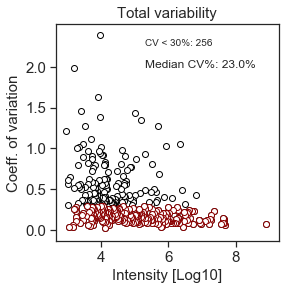

In [18]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(x = df_qc['median_log10'], y = df_qc['var'], facecolor = 'white', edgecolor = 'black')
plt.scatter(x = df_qc_30['median_log10'], y = df_qc_30['var'], facecolor = 'white', edgecolor = 'darkred')
plt.ylabel('Coeff. of variation', fontsize = 15)
plt.title('Total variability', fontsize = 15)
plt.yticks(fontsize = 15, ticks = [0, 0.5, 1, 1.5, 2])
plt.xticks(fontsize = 15)
xlim = plt.gca().get_xlim()
#plt.ylim(-0.1, 2)
#plt.plot(xlim, [0.3, 0.3], color = 'black', lw = 1, ls = '--')
plt.annotate(xy = [0.4, 0.9], xycoords = 'axes fraction', s = 'CV < 30%: {}'.format(df_qc_30.shape[0], fontsize = 12))
plt.annotate(xy = [0.4, 0.8], xycoords = 'axes fraction', s = 'Median CV%: {}%'.format(df_qc['var'].median().round(2)*100), fontsize = 12)
plt.xlabel('Intensity [Log10]', fontsize = 15)
plt.savefig('plasma/figures/cv.png', dpi = 120, bbox_inches = 'tight')

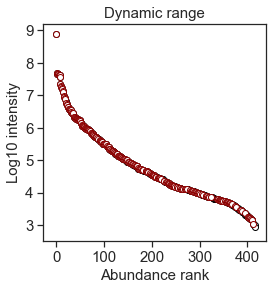

In [19]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(x = df_qc['rank'], y = df_qc['median_log10'], facecolor = 'white', edgecolor = 'black')
plt.scatter(x = df_qc_30['rank'], y = df_qc_30['median_log10'], facecolor = 'white', edgecolor = 'darkred')
plt.ylabel('Log10 intensity', fontsize = 15)
plt.title('Dynamic range', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
xlim = plt.gca().get_xlim()
plt.ylim(2.5, 9.2)
plt.xlabel('Abundance rank', fontsize = 15)
plt.savefig('plasma/figures/dynamic range.png', dpi = 120, bbox_inches = 'tight')

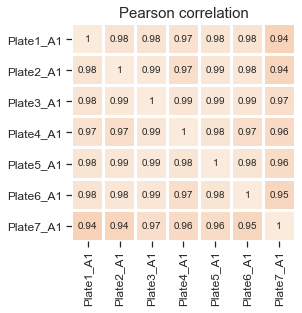

In [20]:
fig, ax = plt.subplots(figsize = (4,4))
sns.set_style('ticks')
sns.heatmap(data_plasma_filtered_log[qc_plasma].corr(),  vmin = 0, vmax = 1, lw =2, annot = True, cbar = False)
sns.set(font_scale=0.9)
plt.title('Pearson correlation', fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(ticks = None, fontsize = 12)
plt.savefig('plasma/figures/qc_corr.png', dpi = 120, bbox_inches = 'tight')

# Liver proteomics data processing

## Dataset processing
- Input data as Spectronaut v13 search engine output (details refer to Methods in the manuscript)
- Filter at protein level for 60% data completeness across all runs
- Filter at individual sample level for total quantified protein groups above 4000
- Log2 transform raw intensity values
- Perform imputation on remaining missing values using a down-shifted Gaussian distribution across sample runs of the same protein

In [21]:
Report_liver = pd.read_csv('liverTissue/raw/Protein_20200221_121354_20200218_ALD_LiverTissue_PlateS1_Atlaslib_Report.csv')
data_liver_raw = extract_datamatrix_DIA(Report_liver)
data_liver_raw = data_liver_raw.drop(data_liver_raw.filter(regex = 'MqLive1010').columns, axis = 1)
to_drop = ['PG.Qvalue', 'PG.MolecularWeight', 'Gene names', 'PG.ProteinDescriptions']
IDmapping_Liver_UniprotID_to_Genename = dict(zip(data_liver_raw['Protein ID'], data_liver_raw['Gene names']))
data_liver_raw = data_liver_raw.drop(to_drop, axis = 1).set_index('Protein ID')

experimental_cols_liver = data_liver_raw.columns

data_liver_filtered = data_liver_raw.dropna(thresh = data_liver_raw.shape[1] * 0.6)
columns_count = [i for i in data_liver_filtered.columns if data_liver_filtered[i].count() > 4000]
data_liver_filtered = data_liver_filtered[columns_count]
data_liver_filtered = convert_to_numeric(data_liver_filtered)

In [22]:
IDmapping_proteinID_to_proteinIDs_plasma = dict(zip(Report_plasma['PG.ProteinAccessions'].str.split(';').str[0], Report_plasma['PG.ProteinAccessions']))
IDmapping_proteinID_to_proteinIDs_liver = dict(zip(Report_liver['PG.ProteinAccessions'].str.split(';').str[0], Report_liver['PG.ProteinAccessions']))

In [23]:
df = data_liver_filtered.copy()
data_liver_filtered_log = log_transform_data(df.astype(np.float64), 2)
data_liver_filtered_log_imputed = imputation_normal_distribution(data_liver_filtered_log.T).T
data_liver_filtered_log_imputed = data_liver_filtered_log_imputed.rename_axis('Sample ID', axis =1)

## Save results

In [24]:
FILE_RESULTS = 'results/proteomics datasets.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    data_liver_raw.to_excel(writer, sheet_name='data_liver_raw')
    data_liver_filtered.to_excel(writer, sheet_name='data_liver_filtered')
    data_liver_filtered_log_imputed.to_excel(writer, sheet_name='data_liver_filtered_log2_imputed')
    data_plasma_raw.to_excel(writer, sheet_name='data_plasma_raw')
    data_plasma_filtered.to_excel(writer, sheet_name='data_plasma_filtered')
    data_plasma_filtered_log_imputed.to_excel(writer, sheet_name='data_plasma_filtered_log2_imputed') 

C:\Users\jpx667\AnacondaProjects\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Data quality assessment
- QC samples are pooled plasma or liver homogenate from study samples, processed together with study samples as early as possible including sample preparation and LC-MS/MS analysis, thus indicate entire workflow variability across sample measurement period. 
- Take raw data as input dataset (before filtering/log2 transformation/imputation)
- calculate coefficient of variation among all QC samples
- Indicate number of proteins with a CV% < 30%, indicate median CV% among all proteins
- Calculate pair-wise Pearson Correlation between QC samples 

### Plotting figures

In [25]:
qc_liver = annotation_file_liver[annotation_file_liver['Groups'] == 'QC_liver']['Sample ID'].to_list()
df_qc_liver = data_liver_raw.copy()
df_qc_liver = convert_to_numeric(df_qc_liver)

In [26]:
sns.set_style('ticks')
df_qc = df_qc_liver[qc_liver].dropna(thresh = 2)
func = lambda x: np.std(x) / np.mean(x)
median = df_qc.median(axis = 1)
var = df_qc.apply(func, axis = 1)
df_qc = df_qc.assign(var = var, median = median)
df_qc = df_qc.sort_values(by = 'median', ascending = False)
df_qc = df_qc.assign(rank = np.arange(df_qc.shape[0]))
df_qc['Gene name'] = df_qc.index.map(IDmapping_Liver_UniprotID_to_Genename)
df_qc['median_log10'] = np.log10(df_qc['median'])
df_qc_30 = df_qc[df_qc['var'] < 0.3]

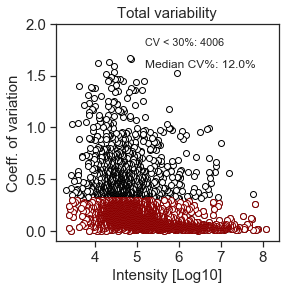

In [27]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(x = df_qc['median_log10'], y = df_qc['var'], facecolor = 'white', edgecolor = 'black')
plt.scatter(x = df_qc_30['median_log10'], y = df_qc_30['var'], facecolor = 'white', edgecolor = 'darkred')
plt.ylabel('Coeff. of variation', fontsize = 15)
plt.title('Total variability', fontsize = 15)
plt.yticks(fontsize = 15, ticks = [0, 0.5, 1, 1.5, 2])
plt.xticks(fontsize = 15)
xlim = plt.gca().get_xlim()
plt.ylim(-0.1, 2)
#plt.plot(xlim, [0.3, 0.3], color = 'black', lw = 1, ls = '--')
plt.annotate(xy = [0.4, 0.9], xycoords = 'axes fraction', s = 'CV < 30%: {}'.format(df_qc_30.shape[0], fontsize = 12))
plt.annotate(xy = [0.4, 0.8], xycoords = 'axes fraction', s = 'Median CV%: {}%'.format(df_qc['var'].median().round(2)*100), fontsize = 12)
plt.xlabel('Intensity [Log10]', fontsize = 15)
plt.savefig('liverTissue/figures/cv.png', dpi = 120, bbox_inches = 'tight')

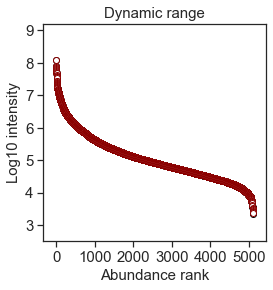

In [28]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(x = df_qc['rank'], y = df_qc['median_log10'], facecolor = 'white', edgecolor = 'black')
plt.scatter(x = df_qc_30['rank'], y = df_qc_30['median_log10'], facecolor = 'white', edgecolor = 'darkred')
plt.ylabel('Log10 intensity', fontsize = 15)
plt.title('Dynamic range', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
xlim = plt.gca().get_xlim()
plt.ylim(2.5, 9.2)
plt.xlabel('Abundance rank', fontsize = 15)
plt.savefig('liverTissue/figures/dynamicRange.png', dpi = 120, bbox_inches = 'tight')

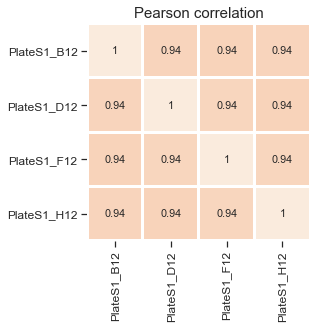

In [29]:
fig, ax = plt.subplots(figsize = (4,4))
sns.set_style('ticks')
sns.heatmap(data_liver_filtered_log[qc_liver].corr(),  vmin = 0, vmax = 1, lw =2, annot = True, cbar = False)
sns.set(font_scale=0.9)
plt.title('Pearson correlation', fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(ticks = None, fontsize = 12)
plt.savefig('liverTissue/figures/qc_corr.png', dpi = 120, bbox_inches = 'tight')

## Connecting clinical data to liver proteome data

In [30]:
df_cli_liver = labtest_numeric.copy()
df_cli_liver['Participant ID'] = df_cli_liver.index.map(dict(zip(annotation_file_plasma['Sample ID'], annotation_file_plasma['Participant ID'])))
df_cli_liver['Sample ID liver'] = df_cli_liver['Participant ID'].map(dict(zip(annotation_file_liver['Participant ID'], annotation_file_liver['Sample ID'])))

In [31]:
df_cli_liver = df_cli_liver.dropna(subset = ['Sample ID liver']).set_index('Sample ID liver')
para_tokeep = ['age', 'kleiner', 'nas', 'nas_inflam', 'nas_steatosis_ordinal', 'gender_num', 'bmi', 'abstinent_num']
dfliver_perseus = data_liver_filtered_log_imputed.copy().T
dfliver_perseus = dfliver_perseus.join(df_cli_liver[para_tokeep]).T
dfliver_perseus['Gene names'] = dfliver_perseus.index.map(IDmapping_Liver_UniprotID_to_Genename)

# ANCOVA

## Preparing dataframes (wide- to long format)

In [32]:
def wide_to_long(df_prot, df_cli, para_to_combine, sample_type='liver'):
    data=df_prot.copy().rename_axis('Sample ID', axis=1)
    data_long=pd.melt(data, value_vars=list(data.columns), value_name='Intensity')
    data_long['Protein ID']=np.tile(data.index, data.shape[1])
    data_long=data_long.assign(type=lambda x: sample_type).set_index('Sample ID')
    data_long_new=data_long.join(df_cli[para_to_combine]).reset_index().set_index('Protein ID')
    return data_long_new

In [33]:
para_to_combine=['age', 'kleiner', 'nas', 'nas_inflam', 'nas_steatosis_ordinal', 'gender_num', 'bmi', 'abstinent_num']

### Long format datasets with unimptuted proteomics data
- Liver

In [34]:
df_prot=data_liver_filtered_log.copy()
df_cli=df_cli_liver.copy()
data_liver_filtered_log_long=wide_to_long(df_prot=df_prot, df_cli=df_cli, para_to_combine=para_to_combine)

- Plasma

In [35]:
df_prot=data_plasma_filtered_log.copy()
df_cli=labtest_numeric.copy()
data_plasma_filtered_log_long=wide_to_long(df_prot=df_prot, df_cli=df_cli, para_to_combine=para_to_combine, sample_type='plasma')

### Long format datasets with imputed proteomics data
- Liver

In [36]:
df_prot=data_liver_filtered_log_imputed.copy()
df_cli=df_cli_liver.copy()
data_liver_filtered_log_imputed_long=wide_to_long(df_prot=df_prot, df_cli=df_cli, para_to_combine=para_to_combine)

- Plasma

In [37]:
df_prot=data_plasma_filtered_log_imputed.copy()
df_cli=labtest_numeric.copy()
data_plasma_filtered_log_imputed_long=wide_to_long(df_prot=df_prot, df_cli=df_cli, para_to_combine=para_to_combine)

## Executing ANCOVA in the plasma proteome

### Covariates included in ANCOVA

In [38]:
hp = annotation_file_plasma[annotation_file_plasma['Group2'] == 'HP']['Sample ID']
data = data_plasma_filtered_log_imputed_long.copy()
data = data[np.logical_not(data['Sample ID'].isin(hp))]
data_fibrosis = data[data['kleiner']!= 0.5]
covar = ['age', 'bmi', 'gender_num', 'abstinent_num', 'nas_steatosis_ordinal']
covar_steatosis = ['age', 'bmi', 'gender_num', 'abstinent_num', 'kleiner', 'nas_inflam']

### Computing

In [39]:
result_ancova_kleiner_p = ancova_pg(data = data_fibrosis, dv = 'Intensity', between = 'kleiner', covar = covar)
result_ancova_inflam_p = ancova_pg(data = data, dv = 'Intensity', between = 'nas_inflam', covar = covar)
result_ancova_steatosis_p = ancova_pg(data = data, dv = 'Intensity', between = 'nas_steatosis_ordinal', covar = covar_steatosis)

C:\Users\jpx667\AnacondaProjects\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Extract significant proteins from ANCOVA results

In [40]:
result_ancova = result_ancova_kleiner_p
sig_ancova = result_ancova[(result_ancova.rejected) & (result_ancova['Source'] == 'kleiner')]
sig_ancova.loc[:]['Gene name'] = sig_ancova['protein'].map(IDmapping_UniprotID_to_Genename)
sig_ancova_kleiner_p = sig_ancova.copy()
print(sig_ancova_kleiner_p.shape)

(192, 10)


In [41]:
result_ancova = result_ancova_inflam_p
sig_ancova = result_ancova[(result_ancova.rejected) & (result_ancova['Source'] == 'nas_inflam')]
sig_ancova.loc[:]['Gene name'] = sig_ancova.protein.map(IDmapping_UniprotID_to_Genename)
sig_ancova_inflam_p = sig_ancova.copy()
print(sig_ancova_inflam_p.shape)

(134, 10)


In [42]:
result_ancova = result_ancova_steatosis_p
sig_ancova = result_ancova[(result_ancova.rejected) & (result_ancova['Source'] == 'nas_steatosis_ordinal')]
sig_ancova.loc[:]['Gene name'] = sig_ancova.protein.map(IDmapping_UniprotID_to_Genename)
sig_ancova_steatosis_p = sig_ancova.copy()
print(sig_ancova_steatosis_p.shape)

(53, 10)


### Plotting Venn diagram

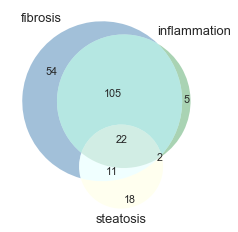

In [43]:
from matplotlib_venn import venn3
fig, ax = plt.subplots(figsize = (4, 4))
sig_list_p = [sig_ancova_kleiner_p.protein, sig_ancova_inflam_p.protein, sig_ancova_steatosis_p.protein]
v = venn3(subsets = [set(i) for i in sig_list_p], set_labels = ['fibrosis', 'inflammation', 'steatosis'], alpha = 0.5,
         set_colors=('steelblue', 'g', 'lightyellow'))
#plt.savefig('plasma/processed/ANCOVA/figures/ancova_venn.pdf', dpi = 80, bbox_inches = 'tight')

### Extract significant proteins ids

In [44]:
fib_p = sig_ancova_kleiner_p['protein'].to_list()
inf_p = sig_ancova_inflam_p['protein'].to_list()
stea_p = sig_ancova_steatosis_p['protein'].to_list()
ancova_all_p = list(set(fib_p + inf_p + stea_p))

## Executing ANCOVA in the liver proteome

In [45]:
data = data_liver_filtered_log_imputed_long.copy()

### Computing

In [46]:
result_ancova_kleiner_l = ancova_pg(data = data, dv = 'Intensity', between = 'kleiner', covar = covar)
result_ancova_inflam_l = ancova_pg(data = data, dv = 'Intensity', between = 'nas_inflam', covar = covar)
result_ancova_steatosis_l = ancova_pg(data = data, dv = 'Intensity', between = 'nas_steatosis_ordinal', covar = covar_steatosis)

### Extract significant proteins from ANCOVA results

In [47]:
result_ancova = result_ancova_steatosis_l
sig_ancova = result_ancova[(result_ancova.rejected) & (result_ancova['Source'] == 'nas_steatosis_ordinal')]
sig_ancova.loc[:]['Gene name'] = sig_ancova.protein.map(IDmapping_Liver_UniprotID_to_Genename)
sig_ancova_steatosis_l = sig_ancova.copy()
print(sig_ancova_steatosis_l.shape)

result_ancova = result_ancova_inflam_l
sig_ancova = result_ancova[(result_ancova.rejected) & (result_ancova['Source'] == 'nas_inflam')]
sig_ancova.loc[:]['Gene name'] = sig_ancova.protein.map(IDmapping_Liver_UniprotID_to_Genename)
sig_ancova_inflam_l = sig_ancova.copy()
print(sig_ancova_inflam_l.shape)

result_ancova = result_ancova_kleiner_l
sig_ancova = result_ancova[(result_ancova.rejected) & (result_ancova['Source'] == 'kleiner')]
sig_ancova.loc[:]['Gene name'] = sig_ancova.protein.map(IDmapping_Liver_UniprotID_to_Genename)
sig_ancova_kleiner_l = sig_ancova.copy()
print(sig_ancova_kleiner_l.shape)

(73, 10)
(148, 10)
(700, 10)


### Extracting significant protein ids

In [48]:
fib_l = sig_ancova_kleiner_l['protein'].to_list()
inf_l = sig_ancova_inflam_l['protein'].to_list()
stea_l = sig_ancova_steatosis_l['protein'].to_list()
ancova_all_l = list(set(fib_l + inf_l + stea_l))

### Plotting Venn diagram

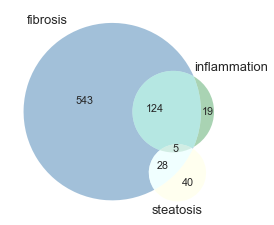

In [49]:
from matplotlib_venn import venn3
fig, ax = plt.subplots(figsize = (4, 4))
sig_list_l = [sig_ancova_kleiner_l.protein, sig_ancova_inflam_l.protein, sig_ancova_steatosis_l.protein]
v = venn3(subsets = [set(i) for i in sig_list_l], set_labels = ['fibrosis', 'inflammation', 'steatosis'], alpha = 0.5,
         set_colors=('steelblue', 'g', 'lightyellow'))
#plt.savefig('liverTissue/processed/ANCOVA/figures/ancova_venn.pdf', dpi = 80, bbox_inches = 'tight')

## Save results

In [50]:
FILE_RESULTS = 'results/ANCOVA_results.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    result_ancova_kleiner_p.to_excel(writer, sheet_name='ANCOVA_plasma_Kleiner')
    result_ancova_inflam_p.to_excel(writer, sheet_name='ANCOVA_plasma_inflammation')
    result_ancova_steatosis_p.to_excel(writer, sheet_name='ANCOVA_plasma_steatosis')
   
    result_ancova_kleiner_l.to_excel(writer, sheet_name='ANCOVA_liver_Kleiner')
    result_ancova_inflam_l.to_excel(writer, sheet_name='ANCOVA_liver_inflammation')
    result_ancova_steatosis_l.to_excel(writer, sheet_name='ANCOVA_liver_steatosis')

### Preparing results as supplementary tables 

- Liver

In [51]:
data=data_liver_filtered_log_long.copy()
df_mean = data.groupby([data.index, 'kleiner']).mean()['Intensity'].unstack()
df_mean.columns=['F'+ str(i) for i in range(5)]
df_mean['F4/F0'] = 2 ** (df_mean.F4 - df_mean.F0)
df_mean['Gene name'] = df_mean.index.map(IDmapping_Liver_UniprotID_to_Genename)
df_mean['ANCOVA significant combined'] = np.where(df_mean.index.isin(ancova_all_l), '+', '')
df_mean['ANCOVA significant fibrosis'] = np.where(df_mean.index.isin(fib_l), '+', '')
df_mean['ANCOVA significant inflammation'] = np.where(df_mean.index.isin(inf_l), '+', '')
df_mean['ANCOVA significant steatosis'] = np.where(df_mean.index.isin(stea_l), '+', '')
data_liver_mean_kleiner = df_mean.copy()

In [52]:
data_liver_mean_kleiner['ANCOVA significant combined'].value_counts()

     4006
+     759
Name: ANCOVA significant combined, dtype: int64

- Plasma

In [53]:
data = data_plasma_filtered_log_long.copy()
df_mean = data.groupby([data.index, 'kleiner']).mean()['Intensity'].unstack()
df_mean = df_mean.drop(0.5, axis = 1)
df_mean.columns=['HP'] + ['F'+ str(i) for i in range(5)]
df_mean['F4/F0'] = 2 ** (df_mean.F4 - df_mean.F0)
df_mean['Gene name'] = df_mean.index.map(IDmapping_UniprotID_to_Genename)
df_mean['ANCOVA significant combined'] = np.where(df_mean.index.isin(ancova_all_p), '+', '')
df_mean['ANCOVA significant fibrosis'] = np.where(df_mean.index.isin(fib_p), '+', '')
df_mean['ANCOVA significant inflammation'] = np.where(df_mean.index.isin(inf_p), '+', '')
df_mean['ANCOVA significant steatosis'] = np.where(df_mean.index.isin(stea_p), '+', '')
df_mean = df_mean.sort_values(by = 'F4/F0', ascending = False)
data_plasma_mean_kleiner = df_mean.copy()

In [54]:
data_plasma_mean_kleiner['ANCOVA significant combined'].value_counts()

+    217
      87
Name: ANCOVA significant combined, dtype: int64

### Save results (significant proteins)

In [55]:
FILE_RESULTS = 'results/ANCOVA_SIG_GroupMeans.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    data_liver_mean_kleiner.to_excel(writer, sheet_name='ANCOVA_liver_mean')
    data_plasma_mean_kleiner.to_excel(writer, sheet_name='ANCOVA_plasma_mean')


# Integration of liver- and plasma proteome data

## Prepare dataset

In [56]:
data_plasma = data_plasma_raw.copy()
data_liver = data_liver_raw.copy()
print('plasma dataset: {}\nliver dataset:{}'.format(data_plasma.shape, data_liver.shape))

data_plasma = data_plasma.rename(mapper = dict(zip(annotation_file_plasma['Sample ID'], annotation_file_plasma['Participant ID'])), axis = 1)
data_liver = data_liver.rename(mapper = dict(zip(annotation_file_liver['Sample ID'], annotation_file_liver['Participant ID'])), axis = 1)

plasma dataset: (524, 603)
liver dataset:(5515, 83)


In [57]:
overlap_liver = pd.read_csv('PLcorr/overlap/overlap_407_liver.csv')['Protein ID'].to_list()
overlap_plasma = pd.read_csv('PLcorr/overlap/overlap_407_plasma.csv')['Protein ID'].to_list()
dict_plasma_IDswap = dict(zip(overlap_plasma, overlap_liver))

In [58]:
overlap_subjects = list(set(data_plasma.columns) & set(data_liver.columns))
print('overlap subject ID number: {}'.format(len(overlap_subjects)))

overlap subject ID number: 79


In [59]:
data_plasma_overlap = data_plasma.loc[overlap_plasma, overlap_subjects]
data_plasma_overlap = data_plasma_overlap.rename(mapper = dict_plasma_IDswap, axis=0)
data_liver_overlap = data_liver.loc[overlap_liver, overlap_subjects]

In [60]:
dict_patiID_kleiner = dict(zip(labtest['Participant ID'], labtest['kleiner']))

### Converting data to long format

In [61]:
long_plasma = pd.melt(data_plasma_overlap, value_vars = list(data_plasma_overlap.columns), value_name = 'Intensity')
long_plasma['index'] = np.tile(data_plasma_overlap.index, data_plasma_overlap.shape[1])
long_plasma = long_plasma.assign(type = lambda x : 'plasma')

long_liver = pd.melt(data_liver_overlap, value_vars = list(data_liver_overlap.columns), value_name = 'Intensity')
long_liver['index'] = np.tile(data_liver_overlap.index, data_liver_overlap.shape[1])
long_liver = long_liver.assign(type = lambda x : 'liver')

long_combined = pd.merge(left= long_plasma, right = long_liver, left_on = ['variable', 'index'], right_on = ['variable', 'index'])
long_combined['kleiner'] = long_combined['variable'].map(dict_patiID_kleiner)
long_combined = long_combined.set_index('index').rename_axis('Protein ID', axis= 0)
long_combined = long_combined.rename({'variable':'Participant ID'})
long_combined = convert_to_numeric(long_combined)

## Exporting data for Dash

In [62]:
PLoverlap_median = pd.DataFrame(data_liver_overlap.T.median(), columns=['liver']).merge(pd.DataFrame(data_plasma_overlap.T.median(), columns=['plasma']), on='Protein ID')
PLoverlap_median = np.log10(PLoverlap_median)
long_combined_export=long_combined.copy()
for i in [PLoverlap_median, long_combined_export]:
    i['Gene name'] = i.index.map(IDmapping_UniprotID_to_Genename)
long_combined_export.to_csv('results/PLoverlap_data.csv')
PLoverlap_median.to_csv('results/PLoverlap_median.csv')

C:\Users\jpx667\AnacondaProjects\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [63]:
data_corr = pd.merge(long_liver, long_plasma, left_on = ['variable', 'index'], right_on = ['variable', 'index'])
data_corr.columns = ['Participant ID', 'Intensity_liver', 'Protein ID', 'type_liver', 'Intensity_plasma', 'type_plasma']
data_corr = pd.merge(data_corr, df_cli_liver, left_on = 'Participant ID', right_on = 'Participant ID' )
data_corr = convert_to_numeric(data_corr)

## Compute pairwise correlation between liver and plasma protein levels

In [64]:
plasma_liver_corr = pairwise_correlation(data = long_combined.drop(['kleiner'], axis = 1), columns = ['Intensity_x'])

C:\Users\jpx667\AnacondaProjects\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Add HPA annotations 

In [65]:
plcorr_tissue = pd.merge(left = plasma_liver_corr, right = tissue_specificity[['RNA tissue category', 'RNA TS TPM']], 
                         left_on = 'Gene name', right_on = 'Gene', how = 'left')
plcorr_tissue.index = plasma_liver_corr.index

In [66]:
corr_false = plcorr_tissue[plcorr_tissue['rejected'] == False].index
corr_true = plcorr_tissue[(plcorr_tissue.rejected) & (abs(plcorr_tissue['r']) >= 0.3)].index

### Extracting significant correlations

In [67]:
sig_corr = plcorr_tissue.loc[corr_true].sort_values(by = 'r', ascending = False)
sig_corr_top= sig_corr[:20].index

In [68]:
sig_corr.shape

(91, 19)

## Save results

In [69]:
sig_corr.to_csv('results/plasma_liver_corr_sig.csv')

## Plotting

In [70]:
def batch_plot_corr(protein, df):
    df_protein = df.loc[protein].dropna(subset=['Intensity_liver', 'Intensity_plasma'])
    r = str(plasma_liver_corr.loc[protein]['r'])
    color_scheme='nas_inflam'
    genename = IDmapping_Liver_UniprotID_to_Genename[protein]
    fig, ax = plt.subplots(figsize= (4,4))
    x = df_protein['Intensity_plasma']
    y = df_protein['Intensity_liver']
    x = np.log2(x)
    y = np.log2(y)
    plt.scatter(x, y, alpha = 1, s= 140, c= df_protein[color_scheme], cmap = 'coolwarm', edgecolor = 'black')
    plt.xlabel('Intensity in plasma [Log2]', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Intensity in liver [Log2]', fontsize = 15)
    plt.title(genename, fontsize = 30)
    plt.annotate(xy=[0.05, 0.9], xycoords = 'axes fraction', s= 'r = {:.2f}'.format(float(r)), fontsize = 25, color='black')
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.savefig('PLcorr/figures/correlation/liver-plasma-corr-{}-{}.pdf'.format(str(genename) + '_' + protein, color_scheme), dpi=210, bbox_inches = 'tight') 

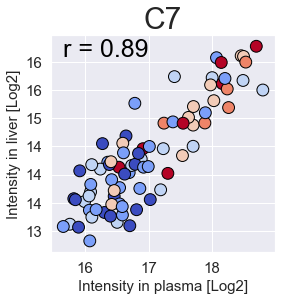

In [71]:
data=data_corr.copy().set_index('Protein ID')
for i in sig_corr.index[1:2]:
    batch_plot_corr(i, df=data)

# Cohort characteristics
- Median (IQR) and Mean (SD)

In [72]:
df_cli = labtest_numeric.copy()
df_cli['group2'] = df_cli.index.map(IDmapping_SampleID_to_Group2)

### Median (IQR)

In [73]:
essential_list = ['age', 'bmi', 'gender_num',  'alt', 'ast', 'alk', 'ggt',
                 'alb', 'bili', 'glc', 'iga', 'igg', 'igm', 'inr', 'mcv', 'currentalc', 'abstinent_num', 'te']

df = labtest_numeric.copy()[essential_list]
df['group2'] = df.index.map(IDmapping_SampleID_to_Group2)
df_ald=df[df['group2']=='ALD']
df_hp=df[df['group2']=='HP']
Median_ald=df_ald.median().round(1)
Median_hp=df_hp.median().round(1)
Median_all=df[essential_list].median().round(1)

ald_p=[np.percentile(df_ald[i].dropna(), [25, 75], interpolation='midpoint') for i in essential_list]
hp_p=[np.percentile(df_hp[i].dropna(), [25, 75], interpolation='midpoint') for i in essential_list]
ALL_p=[np.percentile(df[i].dropna(), [25, 75], interpolation='midpoint') for i in essential_list]

ald_p=[i.round(1) for i in ald_p]
hp_p=[i.round(1) for i in hp_p]
ALL_p=[i.round(1) for i in ALL_p]

IQR_ALD=[(ald_p[i][0], ald_p[i][1]) for i in range(len(ald_p))]
IQR_HP=[(hp_p[i][0], hp_p[i][1]) for i in range(len(hp_p))]
IQR_ALL=[(ALL_p[i][0], ALL_p[i][1]) for i in range(len(ALL_p))]

cohort_cha_median=pd.DataFrame(index=essential_list, data={'Median_ald':Median_ald, 'Median_hp': Median_hp, 'Median_all': Median_all, 'IQR_ald':IQR_ALD, 'IQR_hp':IQR_HP, 'IQR_all':IQR_ALL})

### Mean (SD)

In [74]:
essential_list = ['age', 'bmi', 'gender_num',  'alt', 'ast', 'alk', 'ggt',
                 'alb', 'bili', 'glc', 'iga', 'igg', 'igm', 'inr', 'mcv', 'currentalc', 'abstinent_num', 'te']
df = labtest_numeric.copy()[essential_list]
df['group2'] = df.index.map(IDmapping_SampleID_to_Group2)

In [75]:
MEAN=df.groupby('group2').mean().T.round(1)
MEAN.columns=[i + '_mean' for i in MEAN.columns]
SD=df.groupby('group2').std().T.round(1)
SD.columns=[i + '_sd' for i in SD.columns]
cohort_cha_mean=MEAN.join(SD)

## Save results

In [76]:
FILE_RESULTS = 'Clinical_parameters/results/Patient_characteristics.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    cohort_cha_median.to_excel(writer, sheet_name='Median')
    cohort_cha_mean.to_excel(writer, sheet_name='Mean')

## Plotting

## Distribution of disease severity

### In study participants whose plasma samples were analyzed

In [77]:
hist_scores = ['kleiner', 'nas_inflam', 'nas_steatosis_ordinal']
biopsy_ids_mask = labtest['kleiner'].isin([0, 1, 2, 3, 4])
biopsy_ids = labtest[biopsy_ids_mask]['Participant ID']
plasma_cohortDist = {}
for i in hist_scores:
    plasma_cohortDist[i] = pd.DataFrame(labtest.set_index('Participant ID').reindex(biopsy_ids)[i].value_counts(1).round(2))
    plasma_cohortDist[i] = plasma_cohortDist[i].sort_index()*100

#### Plotting

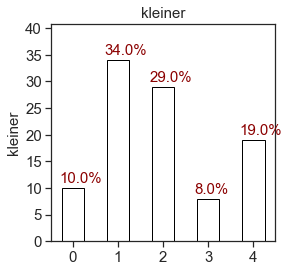

In [78]:
sns.set_style('ticks')
for score in hist_scores[:1]:
    df = plasma_cohortDist[score]
    fig, ax = plt.subplots(figsize = (4, 4))
    height = df[score]
    plt.bar(x = np.arange(df.shape[0]), height = height, 
            facecolor = 'white', edgecolor = 'black', width = 0.5)
    for i, v in enumerate(height):
        ax.text(i-0.3 , v + 1, s = str(round(v, 1)) + '%', color='darkred', fontsize = 15)
    plt.xticks(ticks = np.arange(df.shape[0]), fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylim(0, height.max()*1.2)
    plt.ylabel(score, fontsize = 15)
    plt.title(score, fontsize = 15)
    plt.savefig('Clinical_parameters/plasmaCohort/{}.pdf'.format(score), dpi = 120, bbox_inches = 'tight')

### In study participants whose liver biopsy samples were analyzed

In [79]:
liverTissue_PIDs = annotation_file[(annotation_file['Sample type'] == 'Liver') & (annotation_file['Group2'] == 'ALD')]['Participant ID'].to_list()

hist_scores = ['kleiner', 'nas_inflam', 'nas_steatosis_ordinal']
liver_cohortDist = {}
for i in hist_scores:
    liver_cohortDist[i] = pd.DataFrame(labtest.set_index('Participant ID').reindex(liverTissue_PIDs)[i].value_counts(1).round(2))
    liver_cohortDist[i] = liver_cohortDist[i].sort_index()*100

#### Plotting

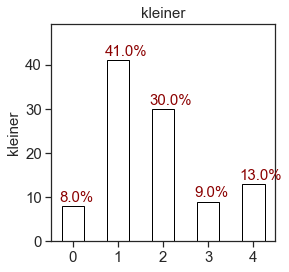

In [80]:
for score in hist_scores[:1]:
    df = liver_cohortDist[score]
    fig, ax = plt.subplots(figsize = (4, 4))
    height = df[score]
    plt.bar(x = np.arange(df.shape[0]), height = height, 
            facecolor = 'white', edgecolor = 'black', width = 0.5)
    for i, v in enumerate(height):
        ax.text(i-0.3 , v + 1, s = str(round(v, 0)) + '%', color='darkred', fontsize = 15)
    plt.xticks(ticks = np.arange(df.shape[0]), fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylim(0, height.max()*1.2)
    plt.ylabel(score, fontsize = 15)
    plt.title(score, fontsize = 15)
    #plt.savefig('Clinical_parameters/tissueCohort/{}.pdf'.format(score), dpi = 120, bbox_inches = 'tight')

In [81]:
IDmapping_liverSampleID_to_ParticipantID = dict(zip(df_cli_liver.index, df_cli_liver['Participant ID']))

# Partial correlation 

## Prepare datasets
- no imputation
- no GALA-HP cohort or the at-risk group in ALD cohort
- only study subjects who had histology examination

In [82]:
df_plasma_proteome = data_plasma_filtered_log_imputed.copy().T
df_clinical = labtest.copy()
df_clinical = df_clinical[np.logical_not(df_clinical.project=='GALA-HP')]
col_to_keep = ['Participant ID', 'project', 'Sample ID', 'kleiner', 'nas_inflam', 'nas_steatosis_ordinal', 'age', 'bmi', 'gender_num', 'abstinent_num']
df_clinical = df_clinical[col_to_keep].set_index('Sample ID')
overlap_parID = intersection(df_plasma_proteome.index.to_list(), df_clinical.index.to_list())
data_plasma_ptcorr = df_plasma_proteome.loc[overlap_parID].join(other = df_clinical)
data_plasma_ptcorr = data_plasma_ptcorr[np.logical_not(data_plasma_ptcorr.kleiner==0.5)]

### Liver dataset for partial correlation

In [83]:
df_liver_proteome = data_liver_filtered_log_imputed.copy().T
overlap_parID = intersection(df_liver_proteome.index.to_list(), df_cli_liver.index.to_list())
col_to_keep = ['Participant ID', 'kleiner', 'nas_inflam', 'nas_steatosis_ordinal', 'age', 'bmi', 'gender_num', 'abstinent_num']
data_liver_ptcorr = df_liver_proteome.loc[overlap_parID].join(other=df_cli_liver[col_to_keep])

## Compute partial correlation

- Liver

In [84]:
data = data_liver_ptcorr.copy()
x_cols = data_liver_filtered.index.to_list()
col_names = ['kleiner', 'nas_inflam', 'nas_steatosis_ordinal']
ptcorr_liver = {}
for i in col_names:
    if i!='nas_steatosis_ordinal':
        ptcorr_liver[i] = partial_corr_pg(data=data, x_cols=x_cols, y_col=i, covar=covar)
    elif i=='nas_steatosis_ordinal':
        ptcorr_liver[i] = partial_corr_pg(data=data, x_cols=x_cols, y_col=i, covar=covar_steatosis)

- Plasma

In [85]:
data = data_plasma_ptcorr.copy()
x_cols = data_plasma_filtered.index.to_list()
col_names = ['kleiner', 'nas_inflam', 'nas_steatosis_ordinal']
ptcorr_plasma = {}
for i in col_names:
    if i!='nas_steatosis_ordinal':
        ptcorr_plasma[i] = partial_corr_pg(data=data, x_cols=x_cols, y_col=i, covar=covar)
    elif i=='nas_steatosis_ordinal':
        ptcorr_plasma[i] = partial_corr_pg(data=data, x_cols=x_cols, y_col=i, covar=covar_steatosis)

### Extract significant correlations

- Liver

In [86]:
ptcorr_liver_sig={}
for i in col_names:
    new_name = i+'_sig'
    ptcorr_liver_sig[new_name] = return_partialcorr_sig(ptcorr_liver[i])
    ptcorr_liver_sig[new_name]['Gene name'] = ptcorr_liver_sig[new_name].index.map(IDmapping_Liver_UniprotID_to_Genename)
    ptcorr_liver_sig[new_name]['predicted to be secreted']=ptcorr_liver_sig[new_name]['Gene name'].map(secreted_dict)

- Plasma

In [87]:
ptcorr_plasma_sig={}
for i in col_names:
    new_name = i+'_sig'
    ptcorr_plasma_sig[new_name] = return_partialcorr_sig(ptcorr_plasma[i], thresh=0.2)
    ptcorr_plasma_sig[new_name]['Gene name'] = ptcorr_plasma_sig[new_name].index.map(IDmapping_UniprotID_to_Genename)
    ptcorr_plasma_sig[new_name]['predicted to be secreted']=ptcorr_plasma_sig[new_name]['Gene name'].map(secreted_dict)

In [88]:
for i in col_names:
    print(i + str(ptcorr_plasma_sig[i+'_sig'].shape[0]))

kleiner151
nas_inflam106
nas_steatosis_ordinal27


## Save results

In [89]:
for i in col_names:
    ptcorr_liver[i].to_csv('liverTissue/processed/PartialCorrelation/result/ptcorr_{}_liver.csv'.format(i))
for i in col_names:
    ptcorr_plasma[i].to_csv('plasma/processed/PartialCorrelation/results/ptcorr_{}_plasma.csv'.format(i))
for i in ptcorr_liver_sig.keys():
    ptcorr_liver_sig[i].to_csv('liverTissue/processed/PartialCorrelation/result/ptcorr_{}_liver.csv'.format(i))

## Plotting
- top 20

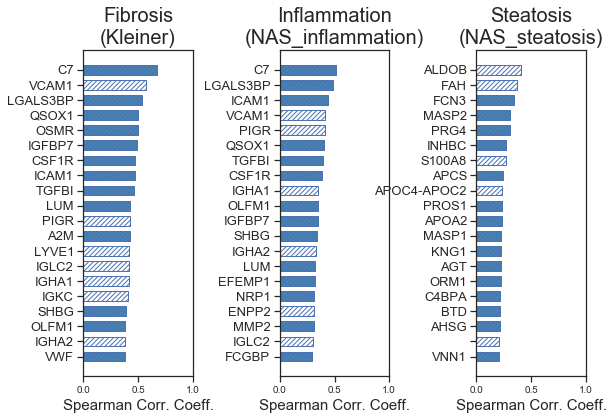

In [90]:
dfs = [ptcorr_plasma_sig[i] for i in ['kleiner_sig', 'nas_inflam_sig', 'nas_steatosis_ordinal_sig']]
sns.set_style('ticks')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9, 6))
dfs = [ptcorr_plasma_sig[i][:20] for i in ['kleiner_sig', 'nas_inflam_sig', 'nas_steatosis_ordinal_sig']]
axs = [ax1, ax2, ax3]
titles = ['Fibrosis\n(Kleiner)', 'Inflammation\n(NAS_inflammation)', 'Steatosis\n(NAS_steatosis)']
for i in range(3):
    ax = axs[i]
    df = dfs[i]
    color = np.where(df['predicted to be secreted']=='secreted', 'steelblue', 'white')
    title = titles[i]
    ax.barh(y = np.arange(20), width = df['r'][::-1], edgecolor = 'b', height = 0.65, color = color[::-1], hatch='/////')
    ax.set_title(title, fontsize = 20)
    ax.set_yticklabels(labels = df['Gene name'][::-1], fontsize = 13)
    ax.set_xlabel('Spearman Corr. Coeff.', fontsize = 15)
    ax.set_yticks(np.arange(20))
    ax.set_xlim(0, 1)
plt.subplots_adjust(wspace = 0.8)
#fig.suptitle('Correlation to histology scores', fontsize = 25);
#plt.savefig('plasma/processed/PartialCorrelation/figures/histology.pdf', dpi = 120, bbox_inches = 'tight')

- top 5 in box plots

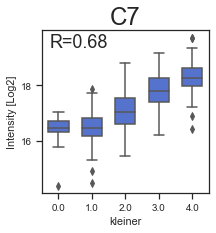

In [91]:
dfs = dfs = [ptcorr_plasma_sig[i] for i in ['kleiner_sig', 'nas_inflam_sig', 'nas_steatosis_ordinal_sig']]
df1 = data_plasma_ptcorr.copy()
df2 = dfs[0]

top_df2 = df2[:4].index.to_list()
parameter = 'kleiner'
for protein in top_df2[:1]:
    r = df2.loc[protein].r
    #GN = IDmapping_Liver_UniprotID_to_Genename[protein]
    GN = IDmapping_UniprotID_to_Genename[protein]
    x = df1[parameter]
    y = df1[protein]
    fig, ax = plt.subplots(figsize = (3,3))
    params = {'xtick.labelsize':15, 
             'ytick.labelsize':15,
             'axes.labelsize':15,
             'axes.titlesize':15}
    sns.boxplot(x = x, y = y, color = 'royalblue', width = 0.6, )
    plt.title(GN, fontsize = 24)
    plt.ylabel('Intensity [Log2]')
    plt.annotate(s = 'R={}'.format(str(r.round(2))), xy = (0.05, 0.9), xycoords = 'axes fraction', fontsize = 18)
    plt.rcParams.update(params)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    #plt.savefig('plasma/processed/PartialCorrelation/figures/{}_{}_{}.pdf'.format(parameter, GN, protein), dpi = 120, bbox_inches= 'tight')

# Global correlation 

## Prepare dataset

In [92]:
df_plasma = data_plasma_filtered_log_imputed.copy().rename_axis('Sample ID', axis = 1)
df_plasma = df_plasma.rename(mapper = IDmapping_SampleID_to_ParticipantID, axis = 1)
df_liver = data_liver_filtered_log_imputed.copy().rename_axis('Sample ID', axis = 1)
df_liver = df_liver.rename(mapper = IDmapping_liverSampleID_to_ParticipantID, axis = 1)
df_cli = labtest_numeric.copy()
df_cli['Participant ID'] = df_cli.index.map(IDmapping_SampleID_to_ParticipantID)
df_cli.set_index('Participant ID', inplace=True)

data_corr_liver=df_liver.T.join(other=df_cli, how='inner')
data_corr_plasma=df_plasma.T.join(other=df_cli, how='inner')

## Correlation of coagulation factors to INR

In [93]:
coag_factors = ['P00734', 'E7END6', 'P00742', 'P03951', 'P07225', 'K7ER74', 'B0YIW2', 'K7ERI9', 'inr']
data_plasma_corr_inr = data_corr_plasma[coag_factors].dropna()
plasma_corr_inr=pg.pairwise_corr(data=data_plasma_corr_inr, columns=['inr'])
bins = [0.65, 0.85, 0.95, 1.05, 1.25, 2.7]
data_plasma_corr_inr['inr_bins'] = pd.cut(data_plasma_corr_inr['inr'], bins)

- Plotting bar plots of coagulation factors as a function of binned INR values

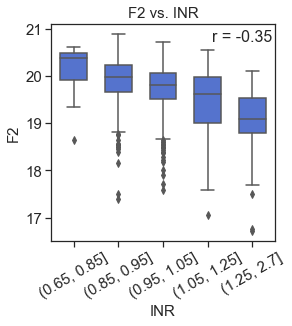

In [94]:
for proteinID in [i for i in coag_factors[:1] if i!='inr']: 
    GN = IDmapping_UniprotID_to_Genename[proteinID]
    r_df = plasma_corr_inr.set_index('Y')
    r = r_df.loc[proteinID]['r']
    fig, ax = plt.subplots(figsize = (4,4))
    sns.boxplot(x = data_plasma_corr_inr['inr_bins'], y = data_plasma_corr_inr[proteinID], color = 'royalblue', width = 0.6)
    #plt.xlim(0.65, 1.65)
    plt.ylabel(GN)
    plt.xlabel('INR')
    plt.xticks(rotation = 30)
    plt.title('{} vs. INR'.format(GN))
    plt.annotate(s = 'r = ' + str(r.round(2)), xy=[0.72, 0.92], xycoords = 'axes fraction', fontsize =16)
    #plt.savefig('Clinical_parameters/figures/inr/{}_INR.png'.format(proteinID), dpi=120, bbox_inches='tight')